<center>
  
# Synthetic Data Evaluation

</center>

In this notebook, we will evaluate the generated synthetic data using both the TabDDPM and TabSyn algorithms based on various metrics. The notebook is organized as follows:

1. [Imports and Setup]()


2. [Density Estimation of Single Column and Pair-wise Correlation]()
    
    
3. [$\alpha$-Precision and $\beta$-Recall ]()

    
4. [Machine Learning Efficiency]()


5. [Privacy Protection: Distance to Closest Record (DCR)]()


6. [Detection: Classifier Two Sample Tests (C2ST)]()

# Imports and Setup

First, we will import functions to evaluate the data using various metrics. Then, we will define the paths to the real train and test data, as well as the TabDDPM and TabSyn generated data.

In [1]:
import json
import os
from pprint import pprint

import torch
from scripts.eval.eval_dcr import eval_dcr
from scripts.eval.eval_density import eval_density
from scripts.eval.eval_detection import eval_detection
from scripts.eval.eval_impute import eval_impute
from scripts.eval.eval_mle import eval_mle
from scripts.eval.eval_quality import eval_quality
from scripts.impute import impute


dataname = "default"

# For shared directory you can change it to "/projects/diffusion_bootcamp/data/tabular"
DATA_DIR = "data"
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, "processed_data")

TRAIN_DATA_PATH = f"{DATA_DIR}/processed_data/{dataname}/train.csv"
TEST_DATA_PATH = f"{DATA_DIR}/processed_data/{dataname}/test.csv"
TABDDPM_DATA_PATH = f"{DATA_DIR}/synthetic_data/{dataname}/tabddpm.csv"
TABSYN_DATA_PATH = f"{DATA_DIR}/synthetic_data/{dataname}/tabsyn.csv"
INFO_PATH = f"{DATA_DIR}/processed_data/{dataname}/info.json"

# Density Estimation of Single Column and Pair-wise Correlation

Two metrics are computed in this section: column shapes and column pair trends.
We explain each in the following subsections.

## Single Column Similarity Score

Essentially, each column in a table represents a single feature which accepts various values from a certain type; e.g. numerical, categorical, datetime or boolean. This feature can be described as a random variable where the values listed under the column are its samples. As a result, the density distribution of each column can be computed and compared between the real data and the synthetic data.

<p align="center">
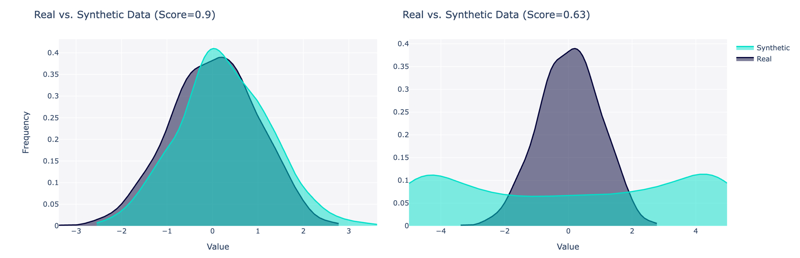
</p>

The better the distributions match each other, the better the quality of synthetic data.

The similarity of the two distriutions can be measured via different metrics for different data types; for example, **KSComplement (Kolmogorov-Smirnov Complement)** is used for numerical features and **TVComplement (Total Variation Distance Complement)** for categorical features. The overall Column Shape Score for the whole table is the average of column shape similarity scores of all columns.

**KST (Kolmogorov-Smirnov Test)**
computes the cumulative distribution function (CDF) of a numerical random variable for real and synthetic data. Then, finds the maximum different between the two CDFs $M$. Finally, the *KSComplement* score is defined as $1 - M$ so that the higher the score, the more similar the distributions.

<p align="center">
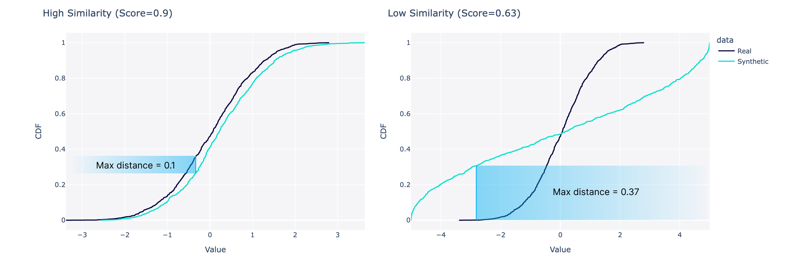
</p>

**TVD (Total Variation Distance)**
computes the frequency of each category's appearance under a certain column and defines it as the said categorie's probability. Then, it computes the sum of differences of probabilities between real and synthetic data as 
$\delta(R, S) = \frac{1}{2} \sum_{\omega \in \Omega}  | R_\omega - S_\omega |$
.

Here, $\omega$ describes all the possible categories in a column, $\Omega$. Meanwhile, $R$ and $S$ refer to the real and synthetic frequencies for those categories. The *TVComplement* returns $1-TVD$ so that a higher score means higher quality.

<p align="center">
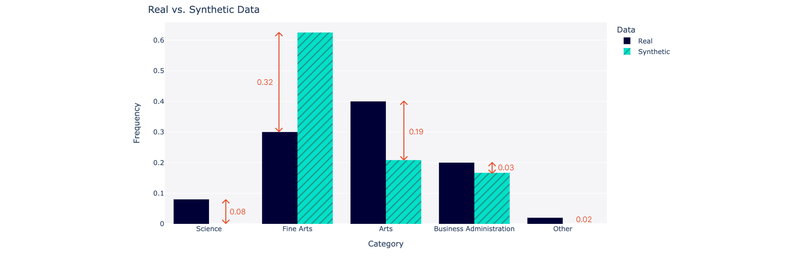
</p>

## Pair-wise Correlation Score

The correlation between two random variables describes how they vary in relation to each other. The higher the score, the more the trends are alike.

<p align="center">
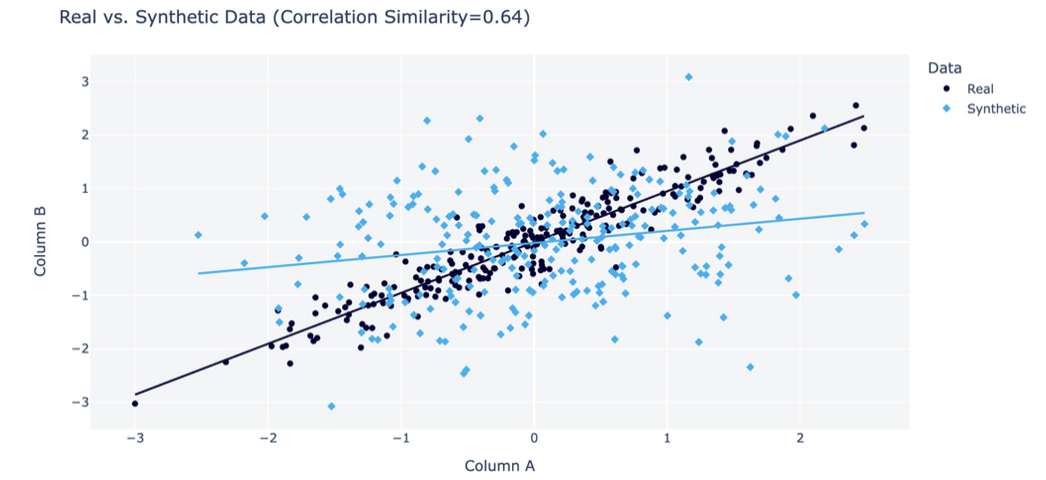
</p>

Here, we use different metrics to compute the correlation between different pairs of data types:

| Column Type | Metric |
| ----------- | ------ |
| numerical & numerical | [correlation similarity](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/correlationsimilarity) |
| categorical & categorical | [contingency similarity](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/contingencysimilarity) |
| numerical & categorical | discretize the numerical columns into bins, then apply contingency similarity. |

This yields a score between every pair of columns. The **Column Pair Trends** score is the average of all the scores.

In [2]:
shape, trend = eval_density(TABDDPM_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH)
print("Shape:", shape)
print("Trend:", trend)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 276/276 [00:17<00:00, 16.08it/s]

Overall Score: 94.3%

Properties:
- Column Shapes: 96.22%
- Column Pair Trends: 92.37%
Shape: 0.9622268518518519
Trend: 0.9236743899096664


In [3]:
shape, trend = eval_density(TABSYN_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH)
print("Shape:", shape)
print("Trend:", trend)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 276/276 [00:17<00:00, 16.01it/s]

Overall Score: 98.22%

Properties:
- Column Shapes: 98.92%
- Column Pair Trends: 97.53%
Shape: 0.9892067901234567
Trend: 0.9752635929036321


# $\alpha$-Precision and $\beta$-Recall 

$\alpha$-Preicison and $\beta$-Recall are generalizations of Precision and Recall metrics proposed by [Sajjadi et al.](https://proceedings.neurips.cc/paper/2018/hash/f7696a9b362ac5a51c3dc8f098b73923-Abstract.html) in 2018. These metrics can range between $[0, 1]$ and the closest they are to $1$ the better.


Preicison measures the fidelity or quality of sythetic data. In more clear terms, it computes the proporation of synthetic datapoints that are *close* to real datapoints. 
Recall, on the other hand, measures the diversity of synthetic data; i.e. the extent to which these samples cover the full variability of real samples. More clearly, recall computes the proportion of real datapoints that are *close* to synthetic datapoints.


If we denote the distibution of real datapoints by $P(X)$ and the distribution of sythetic datapoints by $Q(Y)$, precision is the portion of $Q(Y)$ that can be generated by $P(X)$, while recall is the portion of $P(X)$ that can be generated by $Q(Y)$.

To better understand these concepts, let's assume that the real/generated dataponits are samples from an underlying real/generated manifold.
Precision measures the proportation of generated datapoints that fall on the real manifold, while recall measures the proportion of real datapoints that fall on the generated manifold.

<p align="center">
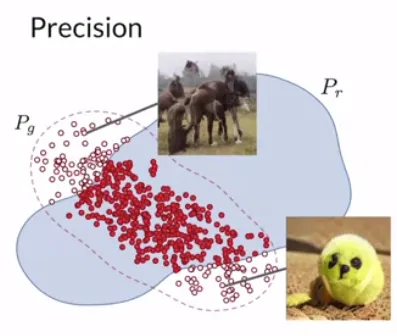
</p>

<p align="center">
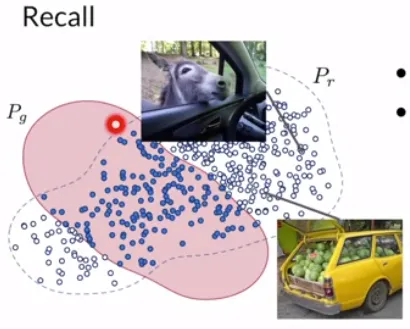
</p>

The Precision-Recall metrics are very sensitive to outliers since even a few outliers can greatly change the shape of the underlying manifold.
To address this limitation, $\pmb{\alpha}$**-Precision** and $\pmb{\beta}$**-Recall** are defined by assuming that a fraction $1−\alpha$ (or $1−\beta$) of the real (and synthetic) data are “outliers”, and $\alpha$ (or $\beta$) are “typical”. 
$\alpha$-Precision is the fraction of synthetic samples that resemble the “most typical” fraction $\alpha$ of real samples, whereas $\beta$-Recall is the fraction of real samples covered by the most typical fraction $\beta$ of synthetic samples.
The two metrics are evaluated for all $\alpha, \beta \in [0, 1]$, providing entire precision and recall curves instead of single numbers.


To illustrate, consider the below image. Blue and red points are real and generated datapoints, respectively. The large blue and red spheres show the underlying manifold that was estimated from real and generated datapoints.
Good quality generated datapoints should fall within the blue sphere like image *(c)*. They should not lie far from the blue sphere like *(a)*. Moreover, they should not be placed too close (or *copied*) to a real datapoint like *(b)*.
Image *(d)* shows an outlier in the real datapoints which is cut outside of the manifold due to the application on $\alpha$ and $\beta$.
If we used vanilla Precision and Recall, the blue sphere's radius should have increased to include the outlier which would also lead it to include noisy synthetic datapoints like *(a)*.

<p align="center">
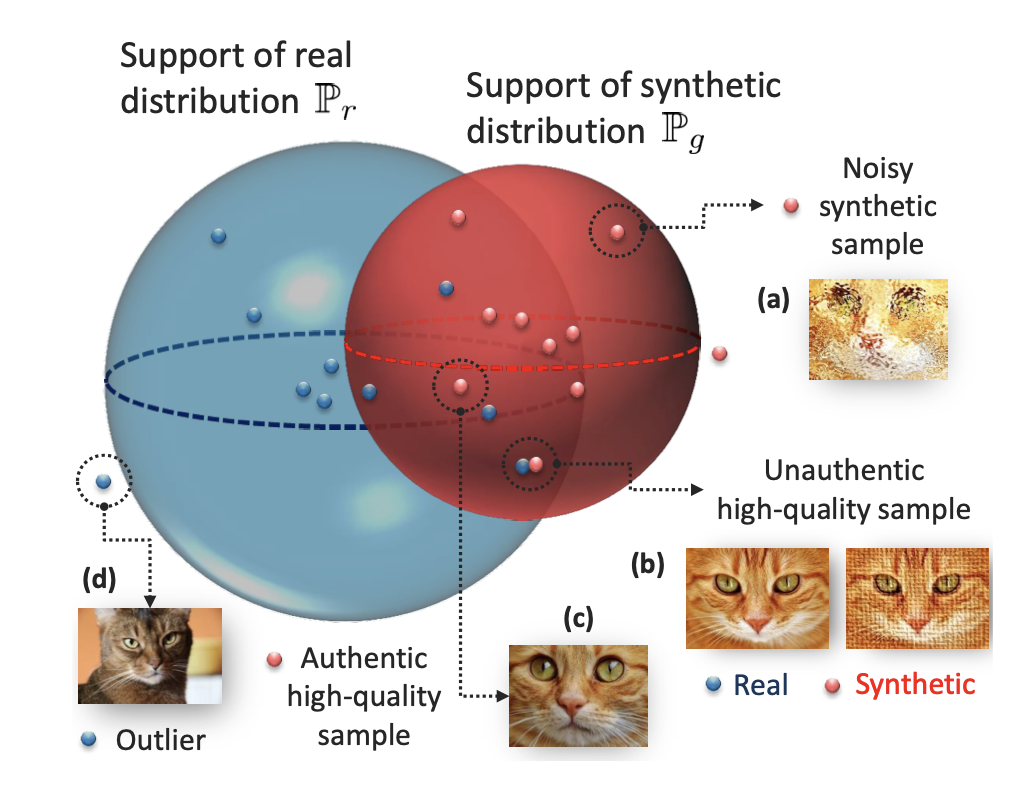
</p>


In [4]:
alpha_precision_all, beta_recall_all = eval_quality(
    TABDDPM_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH
)
print("Alpha precision:", alpha_precision_all)
print("Beta recall:", beta_recall_all)

data/synthetic_data/default/tabddpm.csv
=========== All Features ===========
Data shape:  (27000, 93)
Alpha precision: 0.9097310344827586
Beta recall: 0.4225654320987655


In [5]:
alpha_precision_all, beta_recall_all = eval_quality(
    TABSYN_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH
)
print("Alpha precision:", alpha_precision_all)
print("Beta recall:", beta_recall_all)

data/synthetic_data/default/tabsyn.csv
=========== All Features ===========
Data shape:  (27000, 93)
Alpha precision: 0.984867092379736
Beta recall: 0.4672814814814815


# Machine Learning Efficiency

This method trains a machine learning model (in our case, an XGBoost model) on the synthetic data and evaluates it on the real data.

In [23]:
overall_score = eval_mle(TABDDPM_DATA_PATH, TEST_DATA_PATH, INFO_PATH)
print("TABDDPM - Overall score:")
pprint(overall_score)

100%|██████████| 36/36 [00:19<00:00,  1.84it/s]


TABDDPM - Overall score:
{'best_acc_scores': {'XGBClassifier': {'accuracy': 0.7933333333333333,
                                       'binary_f1': 0.33760683760683763,
                                       'roc_auc': 0.7601092029866403,
                                       'weighted_f1': 0.46413753527497603}},
 'best_auroc_scores': {'XGBClassifier': {'accuracy': 0.791,
                                         'binary_f1': 0.3748753738783649,
                                         'roc_auc': 0.759677258543056,
                                         'weighted_f1': 0.49195986944110637}},
 'best_avg_scores': {'XGBClassifier': {'accuracy': 0.78,
                                       'binary_f1': 0.3785310734463277,
                                       'roc_auc': 0.7168258926387379,
                                       'weighted_f1': 0.49284158594824407}},
 'best_f1_scores': {'XGBClassifier': {'accuracy': 0.78,
                                      'binary_f1': 0.378531073446327

In [14]:
## does a grid search over given params and reports all scores for each best of them
# tabular dataload and tabular transformer look extra
overall_score = eval_mle(TABSYN_DATA_PATH, TEST_DATA_PATH, INFO_PATH)
print("TABSYN - Overall score:")
pprint(overall_score)

100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


TABSYN - Overall score:
{'best_acc_scores': {'XGBClassifier': {'accuracy': 0.8013333333333333,
                                       'binary_f1': 0.43346007604562736,
                                       'roc_auc': 0.7783827752322128,
                                       'weighted_f1': 0.5379931802789568}},
 'best_auroc_scores': {'XGBClassifier': {'accuracy': 0.8113333333333334,
                                         'binary_f1': 0.4526112185686654,
                                         'roc_auc': 0.7847399446739547,
                                         'weighted_f1': 0.5541745076059434}},
 'best_avg_scores': {'XGBClassifier': {'accuracy': 0.8013333333333333,
                                       'binary_f1': 0.43346007604562736,
                                       'roc_auc': 0.7783827752322128,
                                       'weighted_f1': 0.5379931802789568}},
 'best_f1_scores': {'XGBClassifier': {'accuracy': 0.8013333333333333,
                             

As baseline, we also evaluate a similar ML model (i.e. XGBoost) on the real training data.

In [16]:
overall_score = eval_mle(TRAIN_DATA_PATH, TEST_DATA_PATH, INFO_PATH)
print("BASELINE - Overall score:")
pprint(overall_score)

100%|██████████| 36/36 [00:20<00:00,  1.77it/s]


BASELINE - Overall score:
{'best_acc_scores': {'XGBClassifier': {'accuracy': 0.8153333333333334,
                                       'binary_f1': 0.4631782945736434,
                                       'roc_auc': 0.785550885532555,
                                       'weighted_f1': 0.5628421400841354}},
 'best_auroc_scores': {'XGBClassifier': {'accuracy': 0.8153333333333334,
                                         'binary_f1': 0.4631782945736434,
                                         'roc_auc': 0.785550885532555,
                                         'weighted_f1': 0.5628421400841354}},
 'best_avg_scores': {'XGBClassifier': {'accuracy': 0.81,
                                       'binary_f1': 0.4789762340036563,
                                       'roc_auc': 0.7747463913286612,
                                       'weighted_f1': 0.5738436239324902}},
 'best_f1_scores': {'XGBClassifier': {'accuracy': 0.806,
                                      'binary_f1': 0.46210

# Privacy Protection: Distance to Closest Record (DCR)

One of the applications of synthetically generated data is protecting sensitive information while creating similar substitute data that could be used to train machine learning models or published on public platforms.
For this purpose, we must ensure that the synthetic datapoints are far enough from any real datapoints to prevent leaking of real sensitive information.

One metric that is used for this purpose is **Distance to Closest Record (DCR)**.
DCR is the Euclidean distance between a synthetic datapoint and its nearest real datapoint.
DCR equal to zero means that the synthetic datapoint will leak the real information, while higher DCR values mean less risk of privacy leakage.

`eval_dcr` computes the DCR of each synthetic datapoint to real datapoints in two different sets: training and test. Then, it returns the proportion of synthetic datapoints that are closer to the training dataset than the test dataset.
If the size of the training and test datasets are equal, this score should ideally be $0.5$ indicating that the model has not overfit to training data and the synthetic datapoints are not memorized copies of training data.
If the size of the training and test datasets are different, the ideal value for this score is #Train / (#Train + #Test).

In [24]:
# review json file and its contents
with open(INFO_PATH, "r") as file:
    data_info = json.load(file)

In [18]:
ideal_dcr = data_info["train_num"] / (data_info["train_num"] + data_info["test_num"])

dcr_score = eval_dcr(TABDDPM_DATA_PATH, TRAIN_DATA_PATH, TEST_DATA_PATH, INFO_PATH)
print(f"DCR Score, a value closer to {ideal_dcr} is better")
print("Distance to Closest Record:", dcr_score)

DCR Score, a value closer to 0.9 is better
Distance to Closest Record: 0.9014444444444445


In [19]:
ideal_dcr = data_info["train_num"] / (data_info["train_num"] + data_info["test_num"])

dcr_score = eval_dcr(TABSYN_DATA_PATH, TRAIN_DATA_PATH, TEST_DATA_PATH, INFO_PATH)
print(f"DCR Score, a value closer to {ideal_dcr} is better")
print("Distance to Closest Record:", dcr_score)

DCR Score, a value closer to 0.9 is better
Distance to Closest Record: 0.8984814814814814


# Detection: Classifier Two Sample Tests (C2ST)

This metric evaluates if the synthetic data can be detected from the real data via a machine learning model, hence measuring how difficult it is to distinguish synthetic from real data. A logistic regression model is used in `eval_detection`.

This score is measured through below steps:
1. Create a single, augmented table that has all the rows of real data and all the rows of synthetic data. Add an extra column to keep track of whether each original row is real or synthetic.
2. Split the augmented data to create a training and validation sets.
3. Choose a machine learning model. Train the model on the training split. The model will predict whether each row is real or synthetic (i.e. predict the extra column we created in step #1).
4. Validate the model on the validation set.
5. Repeat steps #2-4 multiple times.
The final score is based on the average ROC-AUC score across all the cross validation splits,

$score = 1 - (max($ <span style="text-decoration:overline">ROC-AUC</span> $, 0.5) \times 2 - 1)$
.

This score can range between $[0, 1]$ with $0$ being the lowest (meaning that the machine learning model can perfectly identify synthetic data apart from the real data), and $1$ being the highest (meaning that the machine learning model cannot identify the synthetic data apart from the real data).



In [20]:
detection_score = eval_detection(
    TABSYN_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH, dataname, model="tabsyn"
)
print("TABSYN - Detection score:", detection_score)

TABSYN - Detection score: 0.9729893539094651


In [21]:
detection_score = eval_detection(
    TABDDPM_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH, dataname, model="tabsyn"
)
print("TABDDPM - Detection score:", detection_score)

TABDDPM - Detection score: 0.8972650411522632


In [22]:
detection_score = eval_detection(
    TRAIN_DATA_PATH, TRAIN_DATA_PATH, INFO_PATH, dataname, model="tabsyn"
)
print("BASELINE - Detection score:", detection_score)

BASELINE - Detection score: 1.0


# Missing Value Imputation for the Target Column

We can use a trained TabSyn model for imputation with any missing columns during inference. An interesting application of this is treating classification/regression as missing value imputation tasks. Here's how we approach this:

1. Masking Target Columns:
    - For numerical columns, missing values are replaced with the average values from the training set.
    - For categorical columns, in each imputation trial, we randomly select from all possible categories with uniform probabilities.
2. Feeding Data into the Model:
    - The masked data is fed into the VAE model to obtain embeddings.
3. Applying Diffusion Model Inpainting:
    - We apply diffusion model inpainting to these embeddings to get the imputed embeddings.
    - In diffusion inpainting, the reverse step combines the forward process of known (observed) parts with the backward process of unknown (imputed) parts.
    - For more details on this process, refer to the [RePaint paper](https://arxiv.org/pdf/2201.09865).

Since diffusion inpainting is stochastic, and for categorical columns we randomly sample the category, we need to repeat the imputation algorithm several times (e.g., 50) and take the averaged imputation result as the final result.

In [ ]:
# Change that path to your local modal path to impute
MODEL_PATH = "/projects/diffusion_bootcamp/models/tabular/tabsyn"
IMPUTE_PATH = "impute/tabsyn"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
impute(dataname, PROCESSED_DATA_DIR, INFO_PATH, MODEL_PATH, IMPUTE_PATH, device)

Finally, to evaluate the imputation quality, we compute the ROC-AUC and Micro-F1 score of the imputed target column against the real target column and reported below.

In [30]:
# Uncomment below line to evaluate pre-imputed data
# IMPUTE_PATH = "/projects/diffusion_bootcamp/data/tabular/impute_data/tabsyn"

eval_impute("default", PROCESSED_DATA_DIR, IMPUTE_PATH)

Micro-F1: 0.8066666666666666
AUC: 0.8740092222222221
